In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# # create engine to hawaii.sqlite
# engine = create_engine("sqlite:///hawaii.sqlite")

# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# # reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
M=Base.classes.measurement
S=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(M.tobs), func.avg(M.tobs), func.max(M.tobs)).\
        filter(M.date >= start_date).filter(M.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip_results = calc_temps('2012-02-28', '2012-03-05')
trip_results


[(62.0, 69.57142857142857, 74.0)]

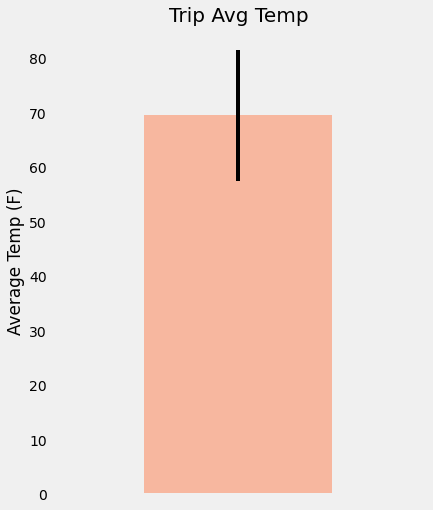

<Figure size 432x288 with 0 Axes>

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Average Temp (F)")
plt.xticks([])
plt.grid()
plt.show()
plt.savefig('..//Images/Trip_avg_Temp.png')



### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start = "2012-02-28"
trip_end = "2012-03-05"

weather_station = (
    session.query(S.station, S.name, S.latitude, S.longitude, S.elevation, func.avg(M.prcp))
    .filter(M.station == S.station, M.date.between(trip_start, trip_end)).group_by(S.station)
    .order_by(func.avg(M.prcp).desc())
    .all()
)

# Convert query object to data frame
rainfall_df = pd.DataFrame(np.array(weather_station))
rainfall_df = rainfall_df.rename(
    columns={
        0: "Station",
        1: "Location",
        2: "Latitude",
        3: "Longitude",
        4: "Elevation",
        5: "Total Precipitation",
    }
)

rainfall_df.head()


,Station,Location,Latitude,Longitude,Elevation,Total Precipitation
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,1.582857142857143
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,1.4742857142857144
2,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6,0.9600000000000001
3,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,0.8271428571428572
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.41714285714285715


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(M.tobs), func.avg(M.tobs), func.max(M.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", M.date) == date).all()

# For example
daily_normals("01-01")


[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date)

# Strip off the year and save a list of strings in the format %m-%d

date_format = trip_dates.strftime('%m-%d')


date_format


Index(['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07'], dtype='object')

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_list = []
for trip_date in date_format:
    normals_list.append(*daily_normals(trip_date))

#make a df
#add trip dates as date index
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')
normals_df

,Tmin,Tavg,Tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


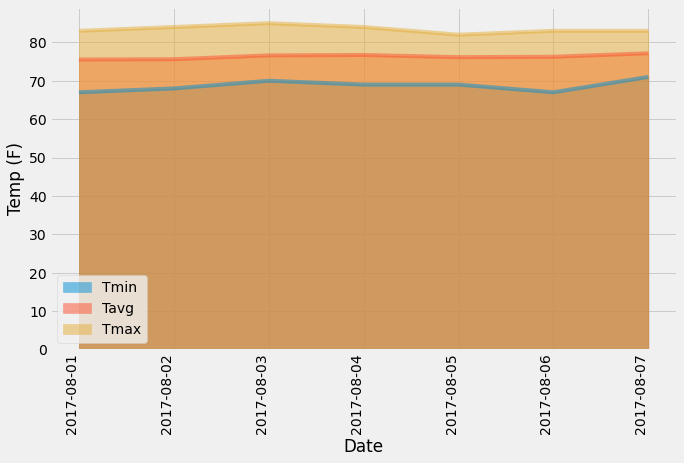

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, x_compat=True, figsize=(10,7), rot=90)
plt.xlabel('Date')
plt.ylabel('Temp (F)')
plt.title='Predicted Temperatures for Trip'
plt.show()
plt.savefig('..//Images/daily_normals.png')

## Close Session

In [19]:
session.close()